In [12]:
import ugradio
import threading
from astropy.io import fits
from astropy.table import Table, Column
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import time
import scipy
import astropy
from scipy.optimize import curve_fit

from scipy.signal import stft
from scipy.signal import argrelextrema as get_extrema_indices

%matplotlib notebook

# 🌠Loading in Data🌠

In [13]:
def data_blob(filename):
    with fits.open(filename) as f:
        vals = []
        for i in range(1,len(f)):
            data = f[i].data
            tab = Table(data)
            vals += [tab[i].data for i in tab.columns]
    return np.array(vals)

In [14]:
#Load in that data boi. Mashallah. Thank you Claire, I stole this from you. I am learning. 
filename_1 = "/Users/sumbal/Desktop/Coding/Sun_HtoH/htohsunactual.fits"
filename_2 = "/Users/sumbal/Desktop/Coding/Sun_HtoH/htohsunactual_p2.fits"
filename_3 = "/Users/sumbal/Desktop/Coding/Sun_HtoH/htohsunactual_p3.fits"

#Have to organize her or else she will die, Astaghfirullah. Will delete first two data point from 
#each set because they are haram. 
sun_data_1 = data_blob(filename_1)[2:]
sun_data_2 = data_blob(filename_2)[2:]
sun_data_3 = data_blob(filename_3)[2:]
print(sun_data_1.shape)
print(sun_data_2.shape)
print(sun_data_3.shape)

(15248, 1024)
(12898, 1024)
(898, 1024)


In [15]:
#There is so much data, so much sun, yipEEEee!
#So lets combine our THREE THICK BOI FILES of sun data into ✨ONE THICKK BOI✨. Mashallah

sun_hh_data = np.concatenate((sun_data_1, sun_data_2, sun_data_3), axis=0)
print(sun_hh_data.shape)

(29044, 1024)


In [16]:
#Now we must deal with the pains of time. She is all one array, so I must slice very carefully. 
#I sound like Hannibal Lecter

unix_times = np.load('times.npz')['data']
unix_times = sorted(unix_times) #Must do this because the times for the last data set were stiched to beginning. 

modified_unix_times = unix_times[2:15251] + unix_times[15253:28151] + unix_times[28153:]

unix_times_differences = np.diff(modified_unix_times)
avg_unix_times_difference = np.mean(unix_times_differences)

print('The average differnece between the unix times is {:0.4} seconds'.format(avg_unix_times_difference))
print('The length of the modified unix times array is {}'.format(len(modified_unix_times)))

The average differnece between the unix times is 1.267 seconds
The length of the modified unix times array is 29044


<IPython.core.display.Javascript object>


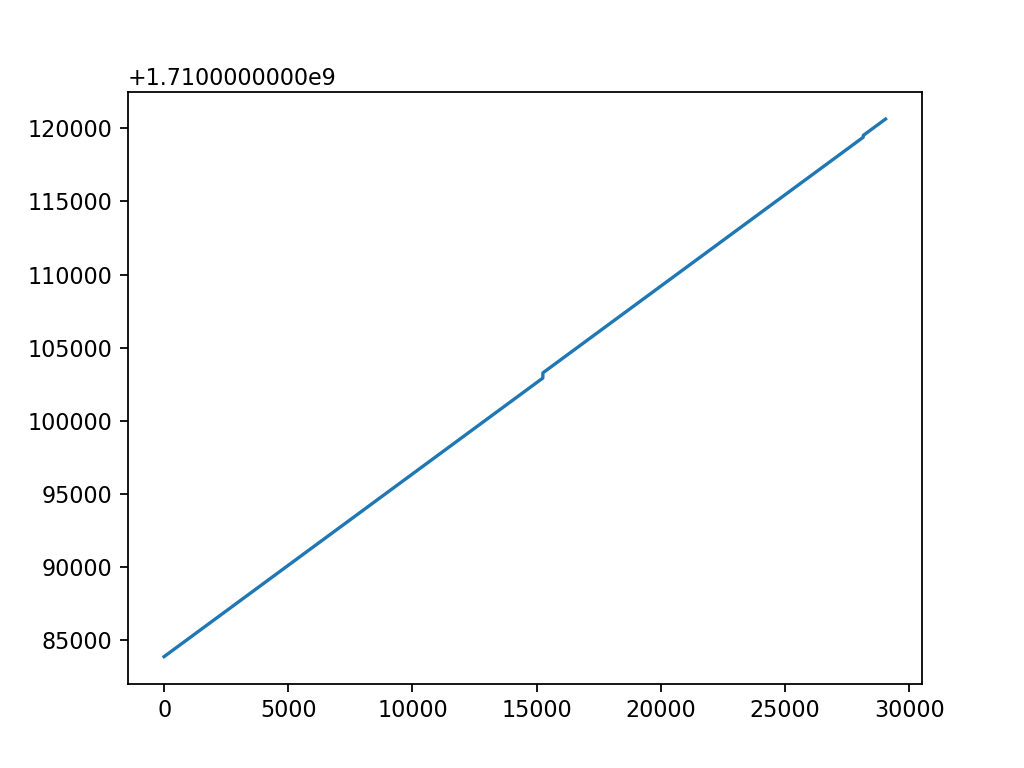

In [17]:
fig, ax = plt.subplots(1,1)
ax.plot(unix_times)

# 🌠Time to Cook🌠

In [18]:
#Lets get the times and channel values I want to work with. I am not a master,
#so going to work at channel 660 becase I think it plotted the least awfully.

visibility_1channel = sun_hh_data[0:, 660]
#visibility_1channel = visibility_1channel - np.mean(visibility_1channel) #Subtracting that mean, Yay!
visibility_1channel.shape

(29044,)

<IPython.core.display.Javascript object>


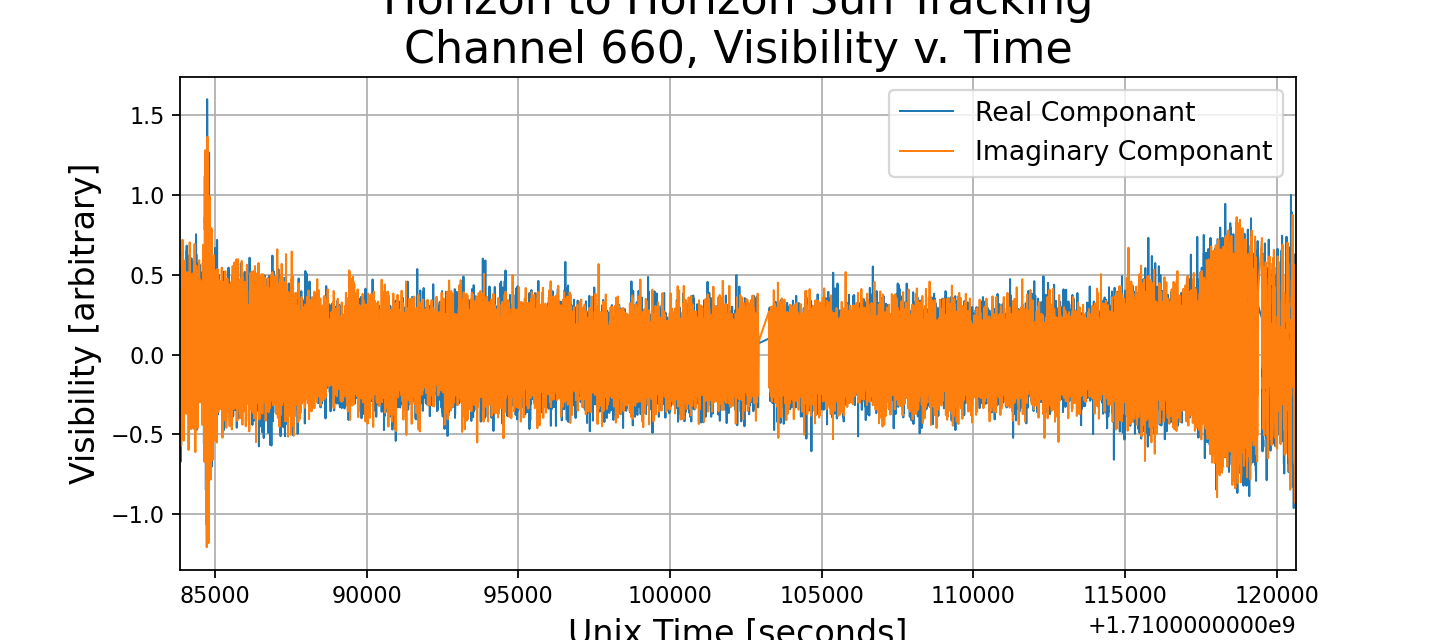

In [19]:
#Now to plot horizon to horizon visibilities. YiPeEEEE!

fig, ax = plt.subplots(1,1,figsize = (9,4))
#ax.plot(visibility_1channel, linewidth = 0.9,label = 'Real Componant')

ax.plot(modified_unix_times, visibility_1channel.real - np.mean(visibility_1channel.real), linewidth = 0.9,label = 'Real Componant')
ax.plot(modified_unix_times, visibility_1channel.imag - np.mean(visibility_1channel.imag), linewidth = 0.9,label = 'Imaginary Componant')

ax.set_xlim(min(unix_times),max(unix_times))

ax.set_xlabel('Unix Time [seconds]', size = 15)
ax.set_ylabel('Visibility [arbitrary]', size = 15)
ax.set_title(r'Horizon to Horizon Sun Tracking'+ '\n' + 'Channel 660, Visibility v. Time', size = 20)

plt.grid()
plt.legend(fontsize = 12)
plt.show()

<IPython.core.display.Javascript object>


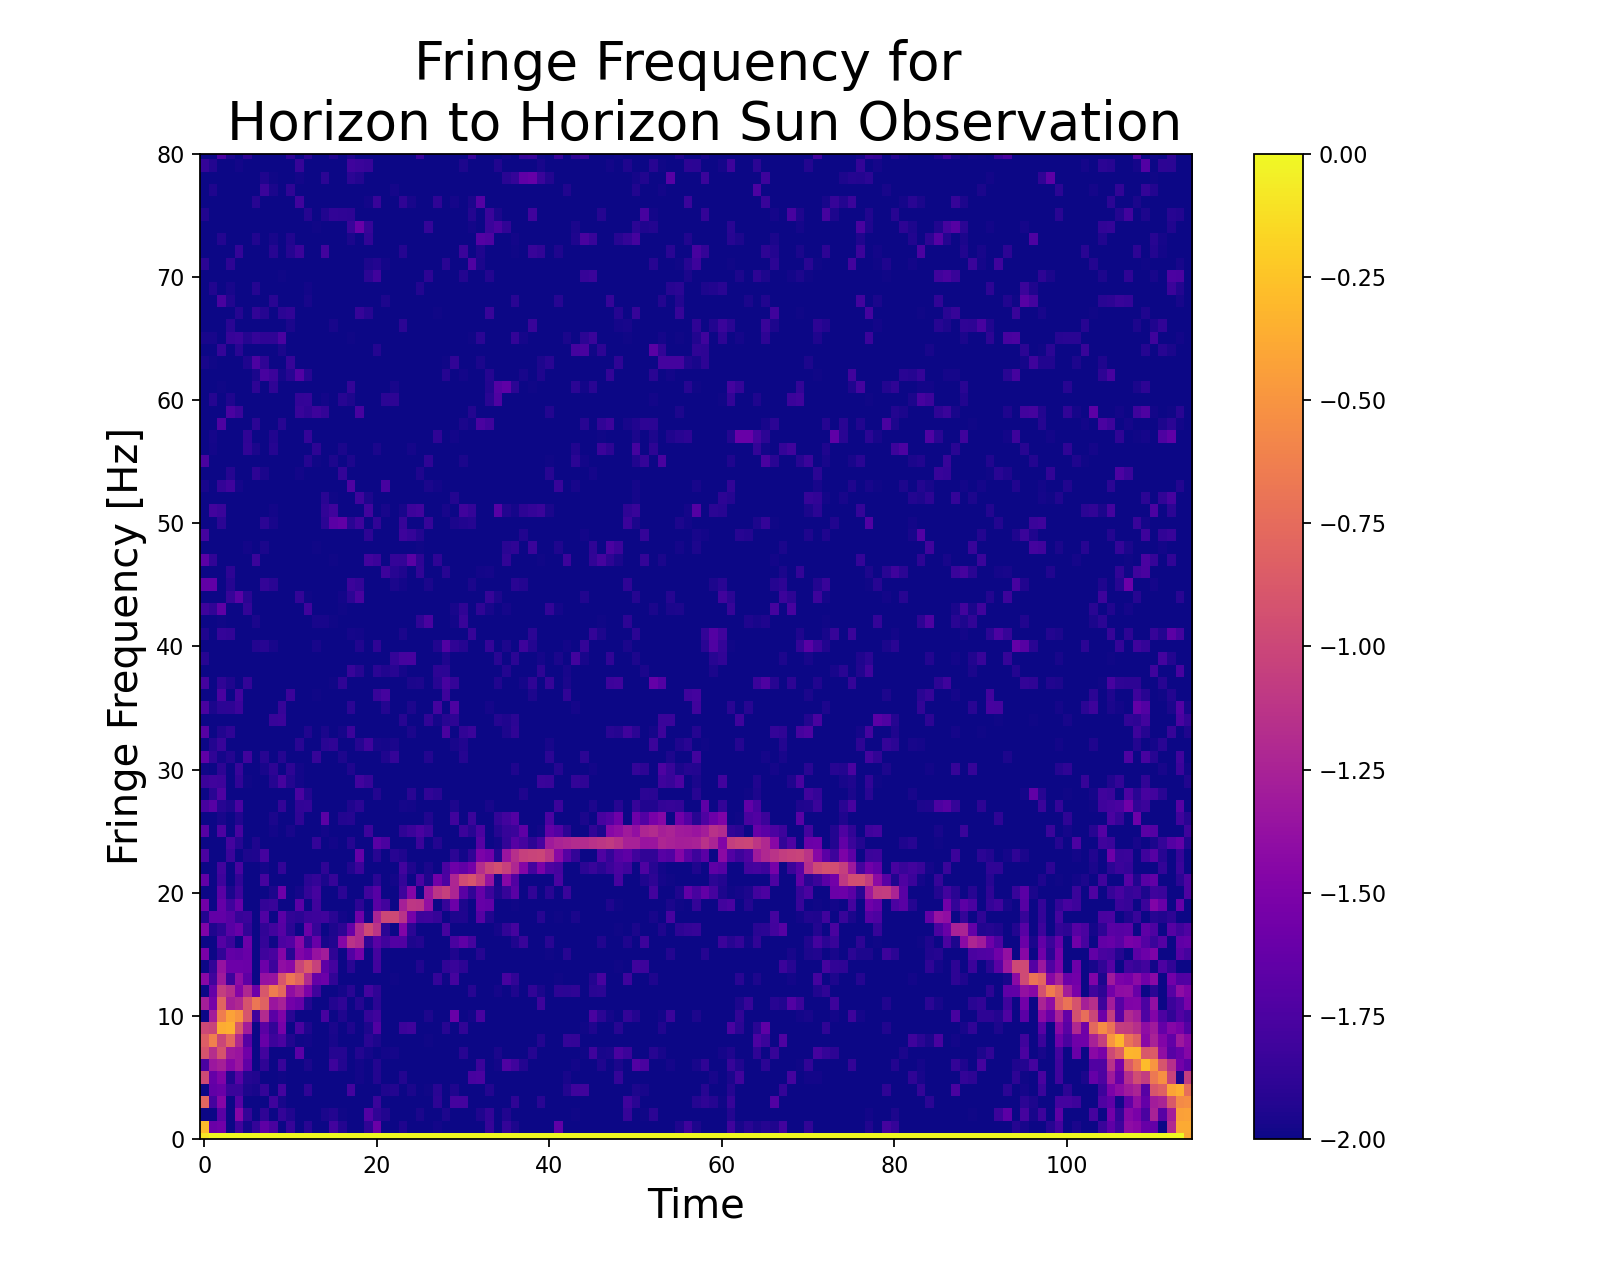

In [23]:
%matplotlib notebook
fringe_freq, tind, data_f = scipy.signal.stft(visibility_1channel, window='boxcar',
                                              fs=1/avg_unix_times_difference, nperseg=512, 
                                              axis=0, return_onesided=False)

fig, ax = plt.subplots(figsize = (10,8))
img = ax.imshow(np.log10(np.abs(data_f)), aspect='auto', interpolation='nearest', cmap='plasma', 
                vmin=-2, vmax=0)
ax.set_ylim(0,80)
cbar = fig.colorbar(img)

plt.xlabel(f'Time', fontsize=18)
plt.ylabel(f'Fringe Frequency [Hz]', fontsize=18)
plt.title(f'Fringe Frequency for \n Horizon to Horizon Sun Observation', fontsize=24)

plt.show()

# 🌠Bessel Time🌠

In [24]:
#I need a way to extract the envelope of the data. So I will use the code I copied from a guy on YouTube. Thank you, Gu 
#Okay wait, I actually ended up NOT usign this. LOL! I will keep it here for safekeepign though for future (mayhaps)

def signal_envelope(signal, frame_size, hop_length = 1):
    amplitude_envelope = []
    
    #Calculating the Amplitude envelope for each frame, yipeee!
    for i in range(0, len(signal), hop_length):
        current_frame_amplitude_envelope = max(signal[i:i+frame_size])
        amplitude_envelope.append(current_frame_amplitude_envelope)
        
    return np.array(amplitude_envelope)

#Note, for genreal use, frame_size should be larger than 

In [26]:
#To Bessel the boi, we must import a think. Why? Because my 19 year old self was cooking when I did this in the past and I like reusing recipies. Alhamdulillah.
from scipy.signal import argrelextrema as get_extrema_indices

<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 32, 35, 38, 41, 44, 47]),)


<IPython.core.display.Javascript object>


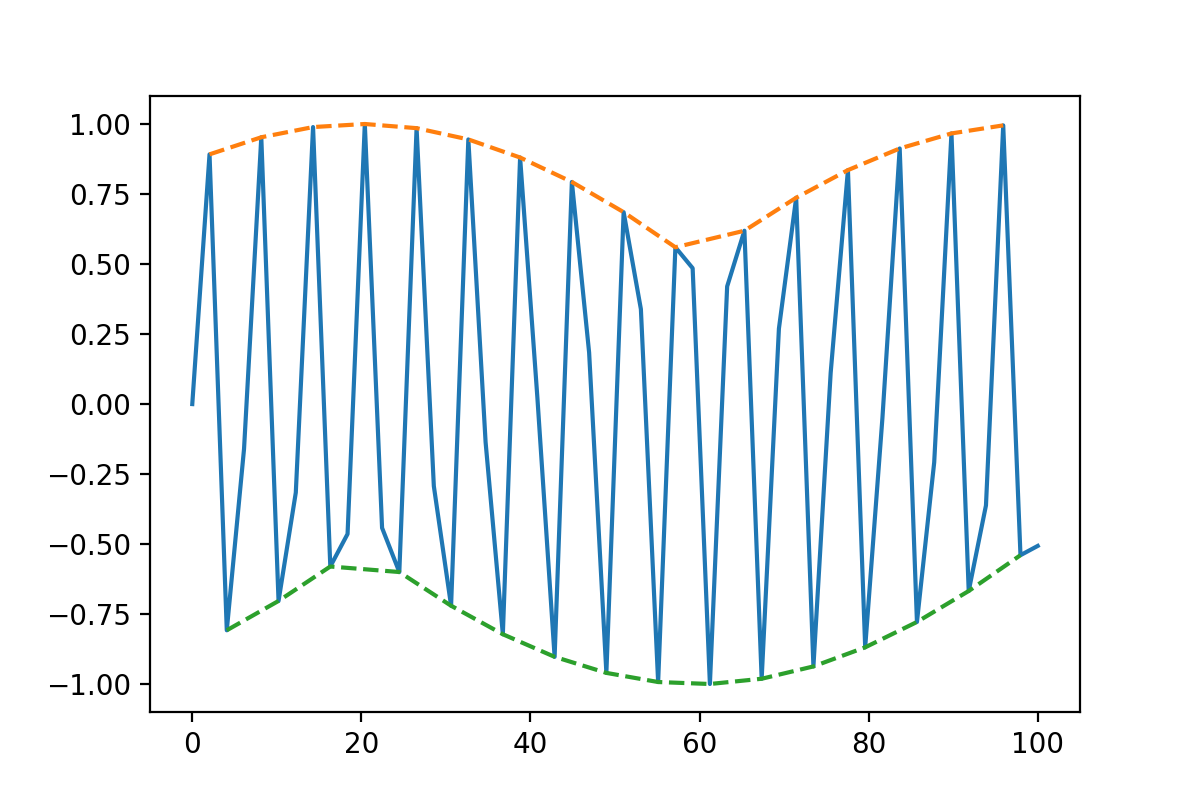

In [12]:
#Wait, I am a little dumb and need to remeber how it worked. Let me so siome simulated waveform first

#Simulated data
simulated_x = np.linspace(0,100,50)
simulated_y = np.sin(simulated_x)

#Envelope... Comparing methods
simulated_envelope = signal_envelope(simulated_y, 2, 1)

neighborhood_size = 2
max_indices = get_extrema_indices(simulated_y, np.greater, order=neighborhood_size)
min_indices = get_extrema_indices(simulated_y, np.less, order=neighborhood_size)
print(type(max_indices))
print(type(simulated_y))
print(type(simulated_y[max_indices]))
print(type(simulated_x))
print(type(simulated_x[max_indices]))
print(max_indices)

fig, ax = plt.subplots(1,1,figsize = (6,4))
ax.plot(simulated_x, simulated_y)
ax.plot(simulated_x[max_indices], simulated_y[max_indices], linestyle = "--")
ax.plot(simulated_x[min_indices], simulated_y[min_indices], linestyle = "--")

#ax.plot(simulated_envelope, linestyle = '--', marker = '.')
#Okay, I remember now. Slaey. 

In [28]:
#Our data is kind of ugly, so we need to slice part where Bessel function exists according to my eyeballs
#Note, I chose the sunset part. I got the values to slice by just looking over the previous horizon to horizon part, Yipeee!
bessel_sample = visibility_1channel[20570:28500]
bessel_sample = np.abs(bessel_sample)
bessel_sample = bessel_sample - np.mean(bessel_sample)

neighborhood_size = 20
unix_time_sample = np.array(modified_unix_times[20570:28500])
max_indices = get_extrema_indices(bessel_sample, np.greater, order=neighborhood_size)

print(type(unix_time_sample))
print(type(bessel_sample))
print(type(max_indices))
bessel_sample_envelope_times = unix_time_sample[max_indices]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>


In [29]:
print(unix_time_sample[0])
print(unix_time_sample[1])

1710109922.768658
1710109923.944309


In [36]:
#Oh wait, lol, need hour angle to put into the bessel approximation boi. Let's do that relaly quick. I have to pee. 
def get_hr(unix_time):
    jd = ugradio.timing.julian_date(unix_time)
    lst_rad = ugradio.timing.lst(jd=jd)
    ra_deg, dec_deg = ugradio.coord.sunpos(jd=jd)
    ra_rad = np.deg2rad(ra_deg)
    ha_rad = lst_rad - ra_rad
    return ha_rad + 2*np.pi  #Note, I got to add 2*pi or else she goes crazy on me. Smh, the audacity. Jk, I get it, me too. 


#Now to transform the unix times we have to hour angle. Que magical girl transformation music. YAY!
ha = np.array([get_hr(i) for i in unix_time_sample])

[8.57564231e+00 2.09689546e-01 4.20711108e-03]


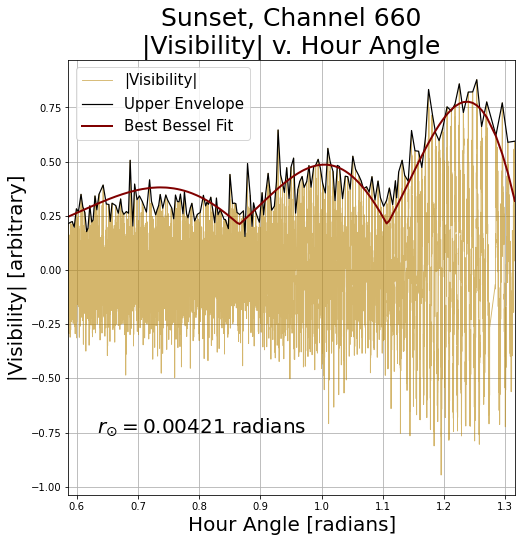

In [40]:
#Okay, not to write out bessle function appriximation function. WOW! Beauiful. Thank you, Mallory. 
%matplotlib inline
def bessel(h, A, b, r):
    u = 14.834/0.025
    return A * (np.abs(scipy.special.j1(2 * np.pi * u * np.cos(h) * r) / (2 * np.pi * u * np.cos(h) * r))) + b

guess = np.array([20, 1, 0.004])
bessel_opt, bessel_cov = curve_fit(bessel, ha[max_indices], bessel_sample[max_indices], guess)


#Not to plot that boi. This is the moment we have been waiting for. Wow. 
fig, ax = plt.subplots(1,1,figsize = (8,8))

ax.plot(ha, bessel_sample, linewidth = 0.9, alpha = 0.6, color = "darkgoldenrod",label = '|Visibility|')
ax.plot(ha[max_indices], bessel_sample[max_indices], linewidth = 1.2,linestyle = "-", color = 'black', label = "Upper Envelope")
ax.plot(ha[max_indices], bessel(ha[max_indices], *bessel_opt), linewidth = 2,linestyle = "-", color = "maroon", label = "Best Bessel Fit")
ax.text(-5.65 + 2*np.pi, -0.75, r'$r_{{\odot}} = {:0.3}$ radians'.format(bessel_opt[2]), size = 20)

ax.set_xlim(min(ha[max_indices]), max(ha[max_indices]))

ax.set_xlabel('Hour Angle [radians]', size = 20)
ax.set_ylabel('|Visibility| [arbitrary]', size = 20)
ax.set_title(r'Sunset, Channel 660'+ '\n' + '|Visibility| v. Hour Angle', size = 25)

plt.grid()
plt.legend(fontsize = 15)
plt.show()

# 🌠Do Not Look Beyond: It is Forbidden by ALLAH🌠

In [ ]:
unix_times_differences = []
for i in range(len(unix_times) - 1):
    if dif > 1:
        dif = unix_times[i+1] - unix_times[i]
    if dif < 1:
        dif = unix_times[i] - unix_times[i-1]
    unix_times_differences.append(dif)
    
#print(unix_times_differences[897])
avg_unix_times_difference = np.mean(unix_times_differences)

print(avg_unix_times_difference)
print(len(unix_times))

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (14,7))
ax.plot(sun_hh_data[660])